In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import glob
import wandb
import os
import torch.optim as optimizers
import pandas as pd
from copy import deepcopy
from ml_collections import ConfigDict 
import tqdm
import torch.nn.functional as F
import torch
import torch.nn as nn
from collections import defaultdict
import yaml
from sklearn.metrics import roc_auc_score
import networkx as nx

import sys
sys.path.append("../../src")
import dfs_code 
from dfs_transformer import collate_downstream, DFSCodeSeq2SeqFC, TrainerGNN, KarateClubDataset
#torch.multiprocessing.set_sharing_strategy('file_system')

import torch_geometric.nn as tnn
import networkx as nx
from torch_geometric.loader import DataLoader


2022-02-03 19:02:29.101390: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/cuda/extras/CUPTI/lib64/:/opt/intel/lib:/opt/intel/mkl/lib/intel64:/opt/intel:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/bin/x86-64_linux:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/python/3.7/x86-64_linux:/opt/intel/clck_latest/lib:/opt/intel/daal/lib:/opt/intel/intelpython3/lib:/opt/intel/ipp/lib:/opt/intel/itac_2019/lib:/opt/intel/itac_latest/lib:/opt/intel/mkl/lib:/opt/intel/mkl_/lib:/opt/intel/mpirt/lib:/opt/intel/tbb/lib:/opt/intel/clck/2019.0/lib:/opt/intel/compilers_and_libraries_2019/linux/lib:/opt/intel/compilers_and_libraries/linux/lib:/opt/intel/itac/2019.0.018/lib:/opt/intel/itac_2019/intel64/lib:/opt/intel/itac_latest/intel64/lib:/opt/intel/parallel_studio_xe_2019.0.045/clck_2019/lib:/opt/intel/parallel_studio_xe_2019.0.045/itac_2019/l

In [3]:
config = wandb.config
config.graph_file = "/mnt/ssd/datasets/graphs/reddit_threads/reddit_edges.json"
config.label_file = "/mnt/ssd/datasets/graphs/reddit_threads/reddit_target.csv"
#config.graph_file = "/mnt/ssd/datasets/graphs/twitch_egos/twitch_edges.json"
#config.label_file = "/mnt/ssd/datasets/graphs/twitch_egos/twitch_target.csv"
config.batch_size = 50
config.n_epochs = 5
config.learning_rate = 0.01
config.rep = 1
config.max_edges = 200
config.n_samples = None#1000#None#None
config.n_channels = 32
config.n_layers = 2
config.model = "tnn.models.GCN"
config.readout = "tnn.global_mean_pool"
config.num_workers = 5
config.training = {}

In [4]:
run = wandb.init(mode="online", project="karateclub-twitch", entity="dfstransformer", 
                 config=config, job_type="evaluation", name="GCN-ones")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chrisxx (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2022-02-03 19:02:32.314666: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/cuda/extras/CUPTI/lib64/:/opt/intel/lib:/opt/intel/mkl/lib/intel64:/opt/intel:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/bin/x86-64_linux:/opt/ibm/ILOG/CPLEX_Studio1210/cplex/python/3.7/x86-64_linux:/opt/intel/clck_latest/lib:/opt/intel/daal/lib:/opt/intel/intelpython3/lib:/opt/intel/ipp/lib:/opt/intel/itac_2019/lib:/opt/intel/itac_latest/lib:/opt/intel/mkl/lib:/opt/intel/mkl_/lib:/opt/intel/mpir

In [5]:
with open(config.graph_file, 'r') as f:
    graph_dict = json.load(f)
label_df = pd.read_csv(config.label_file)

In [6]:
label_df['target'].sum()/len(label_df)

0.5124133380603483

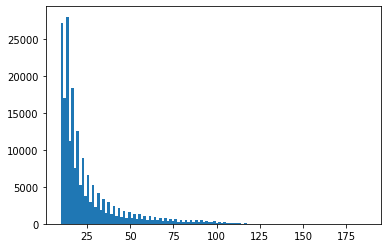

In [7]:
from matplotlib import pyplot as plt
n_edges = [len(graph) for graph in graph_dict.values()]
plt.hist(n_edges, bins='rice')
plt.show()

In [8]:
dataset = KarateClubDataset(config.graph_file, config.label_file, max_n=config.n_samples, max_edges=config.max_edges, n_jobs=4)

203088it [00:41, 4920.74it/s]
203088it [03:27, 977.33it/s] 


In [9]:
len(dataset)

203088

In [10]:
dim_input = dataset[0].x.shape[1]

In [11]:
from einops import rearrange
gnn = eval(config.model)(dim_input, config.n_channels, config.n_layers, 600)

premodel = tnn.Sequential('x, edge_index, batch', [
    (gnn, 'x, edge_index -> x'),
    (eval(config.readout), 'x, batch -> x'),
])

model = tnn.Sequential('x, edge_index, batch', [
    (gnn, 'x, edge_index -> x'),
    (eval(config.readout), 'x, batch -> x'),
    (nn.Linear(600, 2),'x -> x')
])

In [12]:
n = len(dataset)
n_train = int(0.8*n)
n_valid = 0
n_test = n - n_train - n_valid
perm = np.random.permutation(len(dataset))
train_idx = torch.tensor(perm[:n_train], dtype=torch.long)
valid_idx = torch.tensor(perm[n_train:n_train+n_valid].tolist(), dtype=torch.long)
test_idx = torch.tensor(perm[n_train+n_valid:].tolist(), dtype=torch.long)

In [13]:
ce = nn.CrossEntropyLoss()
#ce = nn.BCEWithLogitsLoss()

In [14]:
trainloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(train_idx), 
                         batch_size=config.batch_size, num_workers=config.num_workers)
validloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(valid_idx), 
                         batch_size=config.batch_size, num_workers=config.num_workers)
testloader = DataLoader(dataset, sampler=torch.utils.data.SubsetRandomSampler(test_idx), 
                        batch_size=config.batch_size, num_workers=config.num_workers)

In [15]:
def loss_pretrain(pred, y, l=nn.MSELoss()):
    return l(pred, y)

def loss(pred, y, ce=ce):
    return ce(pred, y.squeeze())

def auc(pred, y):
    try:
        return roc_auc_score(y.detach().cpu().numpy(), pred.detach().cpu().numpy()[:, 1])
    except ValueError:
        return torch.tensor(0.)
    #return roc_auc_score(y.detach().cpu().squeeze().numpy(), pred.detach().cpu().squeeze().numpy())
    

In [16]:
pretrainer = TrainerGNN(premodel, trainloader, loss_pretrain, target='nystroem', n_epochs=config.n_epochs, lr=config.learning_rate, validloader=testloader, 
                  es_period=n_train//config.batch_size, lr_adjustment_period=10*n_train//config.batch_size//4, wandb_run=run,
                  clip_gradient_norm=None, lr_patience=5, es_patience=20)

In [17]:
trainer = TrainerGNN(model, trainloader, loss, metrics={'auc': auc}, n_epochs=config.n_epochs, lr=config.learning_rate, validloader=testloader, 
                  es_period=n_train//config.batch_size, lr_adjustment_period=10*n_train//config.batch_size//4, wandb_run=run,
                  clip_gradient_norm=None, lr_patience=5, es_patience=20)

In [18]:
pretrainer.fit()

Valid 1: loss 0.251240:   3%|████▊                                                                                                                                                | 26/813 [00:02<00:40, 19.38it/s]


Valid 1: loss 0.260276:   7%|██████████▎                                                                                                                                          | 56/813 [00:03<00:30, 24.73it/s]


Valid 1: loss 0.261984:  10%|███████████████▍                                                                                                                                     | 84/813 [00:04<00:33, 21.77it/s]


Valid 1: loss 0.259084:  14%|████████████████████▉                                                                                                                               | 115/813 [00:06<00:30, 23.17it/s]


Valid 1: loss 0.257912:  18%|██████████████████████████                                                                                                                          | 143/813 [00:07<00:30, 22.33it/s]


Valid 1: loss 0.256684:  21%|███████████████████████████████▏                                                                                                                    | 171/813 [00:08<00:29, 21.78it/s]


Valid 1: loss 0.259738:  25%|████████████████████████████████████▊                                                                                                               | 202/813 [00:10<00:25, 24.17it/s]


Valid 1: loss 0.261943:  28%|██████████████████████████████████████████                                                                                                          | 231/813 [00:11<00:27, 21.53it/s]


Valid 1: loss 0.260727:  32%|███████████████████████████████████████████████▎                                                                                                    | 260/813 [00:12<00:26, 21.06it/s]


Valid 1: loss 0.260852:  36%|████████████████████████████████████████████████████▉                                                                                               | 291/813 [00:14<00:19, 26.23it/s]


Valid 1: loss 0.260224:  39%|██████████████████████████████████████████████████████████▎                                                                                         | 320/813 [00:15<00:22, 22.19it/s]


Valid 1: loss 0.260572:  43%|███████████████████████████████████████████████████████████████▋                                                                                    | 350/813 [00:16<00:21, 21.17it/s]


Valid 1: loss 0.260826:  46%|████████████████████████████████████████████████████████████████████▍                                                                               | 376/813 [00:18<00:19, 22.62it/s]


Valid 1: loss 0.262740:  50%|██████████████████████████████████████████████████████████████████████████▍                                                                         | 409/813 [00:19<00:15, 25.72it/s]


Valid 1: loss 0.261952:  54%|███████████████████████████████████████████████████████████████████████████████▋                                                                    | 438/813 [00:20<00:15, 24.26it/s]


Valid 1: loss 0.261609:  58%|█████████████████████████████████████████████████████████████████████████████████████▌                                                              | 470/813 [00:21<00:14, 24.43it/s]


Valid 1: loss 0.261079:  62%|███████████████████████████████████████████████████████████████████████████████████████████                                                         | 500/813 [00:23<00:13, 23.73it/s]


Valid 1: loss 0.260287:  65%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 530/813 [00:24<00:11, 23.84it/s]


Valid 1: loss 0.259970:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 560/813 [00:25<00:09, 27.15it/s]


Valid 1: loss 0.259086:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 593/813 [00:26<00:08, 26.11it/s]


Valid 1: loss 0.258527:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 623/813 [00:27<00:07, 25.74it/s]


Valid 1: loss 0.257983:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 650/813 [00:29<00:06, 24.63it/s]


Valid 1: loss 0.257937:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 682/813 [00:30<00:06, 20.76it/s]


Valid 1: loss 0.257689:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 709/813 [00:31<00:04, 23.36it/s]


Valid 1: loss 0.257153:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 740/813 [00:33<00:03, 22.68it/s]


Valid 1: loss 0.257412:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 770/813 [00:34<00:01, 23.77it/s]


Valid 1: loss 0.257028:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 800/813 [00:35<00:00, 25.17it/s]


Valid 2: loss 0.265628:   2%|██▌                                                                                                                                                  | 14/813 [00:01<00:58, 13.65it/s]


Valid 2: loss 0.240127:   5%|███████▌                                                                                                                                             | 41/813 [00:03<00:41, 18.41it/s]


Valid 2: loss 0.234197:   9%|█████████████▍                                                                                                                                       | 73/813 [00:04<00:35, 20.98it/s]


Valid 2: loss 0.242831:  12%|██████████████████▍                                                                                                                                 | 101/813 [00:06<00:35, 20.32it/s]


Valid 2: loss 0.243030:  16%|███████████████████████▍                                                                                                                            | 129/813 [00:07<00:29, 23.54it/s]


Valid 2: loss 0.243205:  19%|████████████████████████████▊                                                                                                                       | 158/813 [00:08<00:34, 18.81it/s]


Valid 2: loss 0.244199:  23%|██████████████████████████████████▍                                                                                                                 | 189/813 [00:10<00:28, 21.65it/s]


Valid 2: loss 0.243457:  27%|███████████████████████████████████████▎                                                                                                            | 216/813 [00:11<00:29, 20.20it/s]


Valid 2: loss 0.241093:  31%|█████████████████████████████████████████████▏                                                                                                      | 248/813 [00:13<00:28, 19.75it/s]


Valid 2: loss 0.241546:  34%|██████████████████████████████████████████████████▊                                                                                                 | 279/813 [00:14<00:25, 20.93it/s]


Valid 2: loss 0.241433:  38%|███████████████████████████████████████████████████████▋                                                                                            | 306/813 [00:16<00:25, 20.23it/s]


Valid 2: loss 0.241253:  42%|█████████████████████████████████████████████████████████████▌                                                                                      | 338/813 [00:17<00:22, 21.43it/s]


Valid 2: loss 0.240804:  45%|██████████████████████████████████████████████████████████████████▋                                                                                 | 366/813 [00:18<00:22, 19.94it/s]


Valid 2: loss 0.240183:  49%|████████████████████████████████████████████████████████████████████████                                                                            | 396/813 [00:20<00:20, 20.57it/s]


Valid 2: loss 0.240698:  52%|█████████████████████████████████████████████████████████████████████████████▎                                                                      | 425/813 [00:21<00:16, 23.10it/s]


Valid 2: loss 0.240439:  56%|██████████████████████████████████████████████████████████████████████████████████▊                                                                 | 455/813 [00:23<00:15, 23.16it/s]


Valid 2: loss 0.240652:  60%|████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 486/813 [00:24<00:14, 23.02it/s]


Valid 2: loss 0.240665:  63%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 516/813 [00:25<00:15, 19.74it/s]


Valid 2: loss 0.242106:  67%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 546/813 [00:27<00:12, 21.72it/s]


Valid 2: loss 0.242348:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 576/813 [00:28<00:10, 22.90it/s]


Valid 2: loss 0.242395:  75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 606/813 [00:29<00:10, 19.32it/s]


Valid 2: loss 0.241951:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 636/813 [00:31<00:08, 21.98it/s]


Valid 2: loss 0.241910:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 665/813 [00:32<00:05, 25.00it/s]


Valid 2: loss 0.241471:  86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 696/813 [00:33<00:05, 21.05it/s]


Valid 2: loss 0.241831:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 726/813 [00:35<00:04, 21.42it/s]


Valid 2: loss 0.241540:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 759/813 [00:36<00:02, 23.94it/s]


Valid 2: loss 0.241570:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 791/813 [00:38<00:00, 23.47it/s]


Valid 3: loss 0.234840:   1%|█                                                                                                                                                     | 6/813 [00:01<02:16,  5.91it/s]


Valid 3: loss 0.235563:   4%|██████▏                                                                                                                                              | 34/813 [00:02<00:33, 22.99it/s]


Valid 3: loss 0.241950:   8%|███████████▋                                                                                                                                         | 64/813 [00:04<00:34, 21.44it/s]


Valid 3: loss 0.238562:  11%|████████████████▊                                                                                                                                    | 92/813 [00:05<00:37, 19.00it/s]


Valid 3: loss 0.237043:  15%|██████████████████████▍                                                                                                                             | 123/813 [00:06<00:32, 21.41it/s]


Valid 3: loss 0.234218:  19%|███████████████████████████▋                                                                                                                        | 152/813 [00:08<00:31, 21.25it/s]


Valid 3: loss 0.234856:  23%|█████████████████████████████████▎                                                                                                                  | 183/813 [00:09<00:26, 23.64it/s]


Valid 3: loss 0.233600:  26%|██████████████████████████████████████▏                                                                                                             | 210/813 [00:11<00:29, 20.14it/s]


Valid 3: loss 0.235228:  29%|███████████████████████████████████████████▌                                                                                                        | 239/813 [00:12<00:26, 21.74it/s]


Valid 3: loss 0.236658:  33%|█████████████████████████████████████████████████▏                                                                                                  | 270/813 [00:13<00:25, 21.29it/s]


Epoch 3: loss 0.237374: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3246/3250 [02:36<00:00, 28.84it/s]


Valid 3: loss 0.238128:  40%|███████████████████████████████████████████████████████████▉                                                                                        | 329/813 [00:16<00:22, 21.59it/s]


Valid 3: loss 0.237251:  44%|████████████████████████████████████████████████████████████████▊                                                                                   | 356/813 [00:18<00:22, 20.09it/s]


Valid 3: loss 0.237541:  47%|█████████████████████████████████████████████████████████████████████▉                                                                              | 384/813 [00:19<00:23, 18.32it/s]


Valid 3: loss 0.237694:  51%|███████████████████████████████████████████████████████████████████████████▋                                                                        | 416/813 [00:20<00:18, 21.57it/s]


Valid 3: loss 0.237487:  55%|█████████████████████████████████████████████████████████████████████████████████▏                                                                  | 446/813 [00:22<00:17, 20.77it/s]


Valid 3: loss 0.236482:  58%|██████████████████████████████████████████████████████████████████████████████████████▎                                                             | 474/813 [00:23<00:17, 19.78it/s]


Valid 3: loss 0.236067:  62%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 503/813 [00:25<00:15, 20.33it/s]


Valid 3: loss 0.236219:  66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 535/813 [00:26<00:12, 22.82it/s]


Valid 3: loss 0.236692:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 565/813 [00:27<00:11, 20.78it/s]


Valid 3: loss 0.235580:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 593/813 [00:29<00:12, 17.82it/s]


Valid 3: loss 0.235291:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 623/813 [00:30<00:10, 17.47it/s]


Valid 3: loss 0.235185:  80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 654/813 [00:32<00:07, 22.07it/s]


Valid 3: loss 0.234317:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 683/813 [00:33<00:07, 17.66it/s]


Valid 3: loss 0.234418:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 713/813 [00:35<00:05, 18.98it/s]


Valid 3: loss 0.234728:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 742/813 [00:36<00:03, 22.14it/s]


Valid 3: loss 0.234781:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 773/813 [00:38<00:01, 22.04it/s]


Valid 3: loss 0.233882:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 802/813 [00:39<00:00, 23.25it/s]


Valid 4: loss 0.206129:   2%|██▉                                                                                                                                                  | 16/813 [00:01<00:58, 13.53it/s]


Valid 4: loss 0.222809:   6%|████████▏                                                                                                                                            | 45/813 [00:03<00:31, 24.63it/s]


Valid 4: loss 0.230403:   9%|█████████████▉                                                                                                                                       | 76/813 [00:04<00:33, 21.79it/s]


Valid 4: loss 0.230095:  13%|██████████████████▉                                                                                                                                 | 104/813 [00:06<00:29, 23.77it/s]


Valid 4: loss 0.226013:  17%|████████████████████████▊                                                                                                                           | 136/813 [00:07<00:29, 23.01it/s]


Valid 4: loss 0.225787:  20%|██████████████████████████████▏                                                                                                                     | 166/813 [00:08<00:32, 19.94it/s]


Valid 4: loss 0.224491:  24%|███████████████████████████████████▋                                                                                                                | 196/813 [00:10<00:28, 21.56it/s]


Valid 4: loss 0.227393:  28%|█████████████████████████████████████████▌                                                                                                          | 228/813 [00:11<00:25, 23.03it/s]


Valid 4: loss 0.226460:  32%|███████████████████████████████████████████████▌                                                                                                    | 261/813 [00:12<00:24, 22.74it/s]


Valid 4: loss 0.227284:  36%|████████████████████████████████████████████████████▊                                                                                               | 290/813 [00:14<00:21, 24.85it/s]


Valid 4: loss 0.227492:  39%|██████████████████████████████████████████████████████████▍                                                                                         | 321/813 [00:15<00:21, 23.08it/s]


Valid 4: loss 0.226688:  43%|███████████████████████████████████████████████████████████████▉                                                                                    | 351/813 [00:16<00:22, 20.87it/s]


Valid 4: loss 0.226714:  47%|████████████████████████████████████████████████████████████████████▉                                                                               | 379/813 [00:18<00:20, 20.72it/s]


Valid 4: loss 0.226781:  51%|██████████████████████████████████████████████████████████████████████████▊                                                                         | 411/813 [00:19<00:18, 22.04it/s]


Valid 4: loss 0.226520:  54%|████████████████████████████████████████████████████████████████████████████████                                                                    | 440/813 [00:21<00:17, 21.37it/s]


Valid 4: loss 0.226472:  58%|█████████████████████████████████████████████████████████████████████████████████████▍                                                              | 469/813 [00:22<00:18, 18.58it/s]


Valid 4: loss 0.227865:  62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 501/813 [00:23<00:12, 24.38it/s]


Valid 4: loss 0.228842:  65%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 529/813 [00:25<00:13, 21.52it/s]


Valid 4: loss 0.228935:  69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 557/813 [00:26<00:12, 20.41it/s]


Valid 4: loss 0.228379:  73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 592/813 [00:28<00:09, 22.72it/s]


Valid 4: loss 0.228992:  76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 621/813 [00:29<00:07, 24.15it/s]


Valid 4: loss 0.228639:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 652/813 [00:31<00:07, 22.05it/s]


Valid 4: loss 0.228413:  84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 683/813 [00:32<00:06, 20.90it/s]


Valid 4: loss 0.228393:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 712/813 [00:33<00:04, 20.83it/s]


Valid 4: loss 0.228302:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 742/813 [00:35<00:03, 20.91it/s]


Valid 4: loss 0.228077:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 772/813 [00:36<00:02, 17.48it/s]


Valid 4: loss 0.228749:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 802/813 [00:38<00:00, 19.59it/s]


Valid 5: loss 0.206440:   2%|███▍                                                                                                                                                 | 19/813 [00:01<00:48, 16.38it/s]


Valid 5: loss 0.216866:   6%|████████▍                                                                                                                                            | 46/813 [00:03<00:31, 24.04it/s]


Valid 5: loss 0.219855:  10%|██████████████▍                                                                                                                                      | 79/813 [00:04<00:30, 24.10it/s]


Valid 5: loss 0.218432:  13%|███████████████████▋                                                                                                                                | 108/813 [00:05<00:29, 23.67it/s]


Valid 5: loss 0.223869:  17%|████████████████████████▊                                                                                                                           | 136/813 [00:07<00:29, 23.24it/s]


Valid 5: loss 0.222395:  21%|██████████████████████████████▉                                                                                                                     | 170/813 [00:08<00:27, 23.59it/s]


Valid 5: loss 0.222426:  24%|███████████████████████████████████▊                                                                                                                | 197/813 [00:09<00:27, 22.37it/s]


Valid 5: loss 0.221501:  28%|█████████████████████████████████████████▌                                                                                                          | 228/813 [00:11<00:22, 25.90it/s]


Valid 5: loss 0.223758:  32%|██████████████████████████████████████████████▉                                                                                                     | 258/813 [00:12<00:29, 19.07it/s]


Valid 5: loss 0.223611:  35%|████████████████████████████████████████████████████                                                                                                | 286/813 [00:13<00:24, 21.81it/s]


Valid 5: loss 0.225353:  38%|████████████████████████████████████████████████████████▉                                                                                           | 313/813 [00:14<00:20, 24.41it/s]


Valid 5: loss 0.225262:  43%|███████████████████████████████████████████████████████████████▎                                                                                    | 348/813 [00:16<00:22, 20.44it/s]


Valid 5: loss 0.223744:  46%|████████████████████████████████████████████████████████████████████▋                                                                               | 377/813 [00:17<00:19, 22.93it/s]


Valid 5: loss 0.224819:  50%|██████████████████████████████████████████████████████████████████████████                                                                          | 407/813 [00:19<00:17, 23.68it/s]


Valid 5: loss 0.224830:  53%|███████████████████████████████████████████████████████████████████████████████                                                                     | 434/813 [00:20<00:20, 18.50it/s]


Valid 5: loss 0.225819:  57%|████████████████████████████████████████████████████████████████████████████████████▎                                                               | 463/813 [00:21<00:16, 21.50it/s]


Valid 5: loss 0.227001:  61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 493/813 [00:23<00:14, 22.04it/s]


Valid 5: loss 0.226600:  64%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 523/813 [00:24<00:15, 19.11it/s]


Valid 5: loss 0.226825:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 553/813 [00:26<00:13, 19.85it/s]


Valid 5: loss 0.226919:  71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 581/813 [00:27<00:11, 19.66it/s]


Valid 5: loss 0.227010:  75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 611/813 [00:29<00:10, 20.00it/s]


Valid 5: loss 0.227261:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 642/813 [00:30<00:06, 26.84it/s]


Valid 5: loss 0.226891:  82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 669/813 [00:31<00:06, 21.09it/s]


Valid 5: loss 0.226926:  86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 699/813 [00:33<00:05, 20.79it/s]


Valid 5: loss 0.226315:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 728/813 [00:34<00:04, 19.72it/s]


Valid 5: loss 0.226601:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 757/813 [00:36<00:02, 21.36it/s]


Valid 5: loss 0.226833:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 785/813 [00:37<00:01, 21.27it/s]


Epoch 5: loss 0.227706: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3250/3250 [02:55<00:00, 18.54it/s]


In [19]:
trainer.fit()

Valid 1: loss 0.521532 0.8466:   3%|████▎                                                                                                                                         | 25/813 [00:02<00:35, 22.30it/s]


Valid 1: loss 0.521472 0.7440:   7%|█████████▍                                                                                                                                    | 54/813 [00:03<00:37, 20.50it/s]


Valid 1: loss 0.517542 0.8542:  10%|██████████████▋                                                                                                                               | 84/813 [00:05<00:37, 19.67it/s]


Valid 1: loss 0.518921 0.7258:  14%|███████████████████▎                                                                                                                         | 111/813 [00:06<00:35, 20.02it/s]


Valid 1: loss 0.517371 0.9195:  18%|████████████████████████▊                                                                                                                    | 143/813 [00:07<00:31, 20.98it/s]


Valid 1: loss 0.518588 0.8344:  21%|█████████████████████████████▋                                                                                                               | 171/813 [00:09<00:32, 19.93it/s]


Valid 1: loss 0.517865 0.9058:  25%|██████████████████████████████████▋                                                                                                          | 200/813 [00:10<00:29, 21.12it/s]


Valid 1: loss 0.519969 0.6867:  28%|████████████████████████████████████████                                                                                                     | 231/813 [00:12<00:28, 20.15it/s]


Valid 1: loss 0.523766 0.7788:  32%|█████████████████████████████████████████████                                                                                                | 260/813 [00:13<00:22, 24.62it/s]


Valid 1: loss 0.525167 0.7532:  36%|██████████████████████████████████████████████████▍                                                                                          | 291/813 [00:14<00:20, 25.80it/s]


Valid 1: loss 0.525179 0.8658:  39%|███████████████████████████████████████████████████████▋                                                                                     | 321/813 [00:16<00:22, 21.51it/s]


Valid 1: loss 0.527568 0.8768:  43%|████████████████████████████████████████████████████████████▌                                                                                | 349/813 [00:17<00:23, 19.71it/s]


Valid 1: loss 0.527906 0.8213:  46%|█████████████████████████████████████████████████████████████████▌                                                                           | 378/813 [00:18<00:18, 23.57it/s]


Valid 1: loss 0.527227 0.8421:  50%|██████████████████████████████████████████████████████████████████████▊                                                                      | 408/813 [00:19<00:18, 22.24it/s]


Valid 1: loss 0.526555 0.8483:  54%|███████████████████████████████████████████████████████████████████████████▍                                                                 | 435/813 [00:21<00:19, 19.35it/s]


Valid 1: loss 0.528280 0.7633:  57%|████████████████████████████████████████████████████████████████████████████████▍                                                            | 464/813 [00:22<00:18, 18.54it/s]


Valid 1: loss 0.527163 0.7744:  61%|█████████████████████████████████████████████████████████████████████████████████████▌                                                       | 493/813 [00:24<00:14, 22.77it/s]


Valid 1: loss 0.527051 0.9002:  64%|██████████████████████████████████████████████████████████████████████████████████████████                                                   | 519/813 [00:25<00:14, 19.89it/s]


Valid 1: loss 0.526906 0.9838:  67%|███████████████████████████████████████████████████████████████████████████████████████████████                                              | 548/813 [00:27<00:12, 20.64it/s]


Valid 1: loss 0.525562 0.8542:  71%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 578/813 [00:28<00:11, 20.46it/s]


Valid 1: loss 0.525639 0.7297:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 604/813 [00:30<00:13, 15.64it/s]


Valid 1: loss 0.525830 0.8792:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 635/813 [00:31<00:09, 19.54it/s]


Valid 1: loss 0.525870 0.8454:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 664/813 [00:32<00:07, 19.26it/s]


Valid 1: loss 0.526269 0.8535:  85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 693/813 [00:34<00:06, 19.70it/s]


Valid 1: loss 0.525989 0.8454:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 727/813 [00:35<00:03, 21.57it/s]


Valid 1: loss 0.525425 0.7965:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 753/813 [00:37<00:03, 18.46it/s]


Valid 1: loss 0.525780 0.9075:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 786/813 [00:38<00:01, 21.41it/s]


Valid 2: loss 0.486534 0.8374:   0%|▏                                                                                                                                              | 1/813 [00:01<16:11,  1.20s/it]


Valid 2: loss 0.514875 0.8333:   4%|█████                                                                                                                                         | 29/813 [00:02<00:38, 20.20it/s]


Valid 2: loss 0.513186 0.8558:   7%|█████████▉                                                                                                                                    | 57/813 [00:04<00:42, 17.95it/s]


Valid 2: loss 0.510568 0.8261:  11%|███████████████▏                                                                                                                              | 87/813 [00:05<00:38, 18.89it/s]


Valid 2: loss 0.508544 0.9127:  14%|███████████████████▉                                                                                                                         | 115/813 [00:07<00:32, 21.61it/s]


Valid 2: loss 0.509844 0.8475:  18%|█████████████████████████▎                                                                                                                   | 146/813 [00:08<00:35, 18.88it/s]


Valid 2: loss 0.508868 0.9017:  21%|██████████████████████████████                                                                                                               | 173/813 [00:10<00:34, 18.67it/s]


Valid 2: loss 0.509762 0.7036:  25%|███████████████████████████████████▏                                                                                                         | 203/813 [00:11<00:32, 18.75it/s]


Valid 2: loss 0.512160 0.8381:  28%|████████████████████████████████████████                                                                                                     | 231/813 [00:13<00:35, 16.45it/s]


Valid 2: loss 0.508707 0.8502:  32%|█████████████████████████████████████████████▎                                                                                               | 261/813 [00:14<00:29, 18.53it/s]


Valid 2: loss 0.509553 0.8818:  36%|██████████████████████████████████████████████████▊                                                                                          | 293/813 [00:16<00:25, 20.02it/s]


Valid 2: loss 0.507161 0.8776:  40%|████████████████████████████████████████████████████████                                                                                     | 323/813 [00:17<00:27, 18.02it/s]


Valid 2: loss 0.505420 0.8422:  43%|████████████████████████████████████████████████████████████▊                                                                                | 351/813 [00:19<00:27, 16.57it/s]


Valid 2: loss 0.505998 0.8194:  47%|██████████████████████████████████████████████████████████████████                                                                           | 381/813 [00:20<00:22, 19.60it/s]


Valid 2: loss 0.504622 0.8928:  51%|███████████████████████████████████████████████████████████████████████▎                                                                     | 411/813 [00:21<00:19, 20.12it/s]


Valid 2: loss 0.504693 0.8312:  54%|████████████████████████████████████████████████████████████████████████████▍                                                                | 441/813 [00:23<00:16, 22.08it/s]


Valid 2: loss 0.503494 0.8977:  58%|█████████████████████████████████████████████████████████████████████████████████▏                                                           | 468/813 [00:24<00:17, 19.89it/s]


Valid 2: loss 0.503196 0.8961:  61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 496/813 [00:26<00:14, 21.50it/s]


Valid 2: loss 0.503515 0.8801:  65%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 530/813 [00:27<00:12, 21.81it/s]


Valid 2: loss 0.503707 0.7354:  69%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 558/813 [00:28<00:11, 22.45it/s]


Valid 2: loss 0.502964 0.7980:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 588/813 [00:30<00:10, 21.08it/s]


Valid 2: loss 0.502869 0.8530:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 618/813 [00:31<00:10, 18.81it/s]


Valid 2: loss 0.504017 0.7589:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 651/813 [00:33<00:06, 23.66it/s]


Valid 2: loss 0.504591 0.8831:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 682/813 [00:34<00:05, 22.57it/s]


Valid 2: loss 0.504497 0.8815:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 709/813 [00:35<00:04, 25.15it/s]


Valid 2: loss 0.505480 0.7810:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 739/813 [00:37<00:03, 24.15it/s]


Valid 2: loss 0.505958 0.8277:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 769/813 [00:38<00:01, 25.63it/s]


Valid 2: loss 0.506331 0.8606:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 799/813 [00:39<00:00, 22.73it/s]


Valid 3: loss 0.514406 0.7360:   1%|██                                                                                                                                            | 12/813 [00:01<01:06, 12.03it/s]


Valid 3: loss 0.504555 0.8849:   5%|███████▏                                                                                                                                      | 41/813 [00:03<00:33, 23.02it/s]


Valid 3: loss 0.500281 0.8112:   9%|████████████▍                                                                                                                                 | 71/813 [00:04<00:43, 16.87it/s]


Valid 3: loss 0.504946 0.7375:  12%|█████████████████▌                                                                                                                           | 101/813 [00:06<00:40, 17.57it/s]


Valid 3: loss 0.499071 0.8177:  16%|██████████████████████▋                                                                                                                      | 131/813 [00:07<00:30, 22.22it/s]


Valid 3: loss 0.499640 0.9733:  20%|███████████████████████████▌                                                                                                                 | 159/813 [00:09<00:30, 21.68it/s]


Valid 3: loss 0.498908 0.8438:  23%|████████████████████████████████▊                                                                                                            | 189/813 [00:10<00:30, 20.51it/s]


Valid 3: loss 0.496620 0.8390:  27%|█████████████████████████████████████▍                                                                                                       | 216/813 [00:12<00:33, 18.07it/s]


Valid 3: loss 0.497502 0.9188:  31%|███████████████████████████████████████████                                                                                                  | 248/813 [00:13<00:26, 21.58it/s]


Valid 3: loss 0.500477 0.8815:  34%|████████████████████████████████████████████████                                                                                             | 277/813 [00:14<00:26, 20.48it/s]


Valid 3: loss 0.500279 0.7240:  38%|█████████████████████████████████████████████████████▊                                                                                       | 310/813 [00:16<00:21, 23.28it/s]


Valid 3: loss 0.499599 0.8156:  42%|██████████████████████████████████████████████████████████▊                                                                                  | 339/813 [00:17<00:22, 20.98it/s]


Valid 3: loss 0.501249 0.7931:  45%|███████████████████████████████████████████████████████████████▊                                                                             | 368/813 [00:19<00:23, 19.17it/s]


Valid 3: loss 0.500724 0.8622:  49%|████████████████████████████████████████████████████████████████████▋                                                                        | 396/813 [00:20<00:21, 19.85it/s]


Valid 3: loss 0.500575 0.7258:  52%|█████████████████████████████████████████████████████████████████████████▉                                                                   | 426/813 [00:22<00:20, 18.72it/s]


Valid 3: loss 0.501450 0.8815:  56%|██████████████████████████████████████████████████████████████████████████████▌                                                              | 453/813 [00:23<00:17, 20.04it/s]


Valid 3: loss 0.499827 0.8637:  60%|████████████████████████████████████████████████████████████████████████████████████                                                         | 485/813 [00:24<00:13, 24.10it/s]


Valid 3: loss 0.499675 0.8181:  63%|████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 511/813 [00:26<00:16, 18.62it/s]


Valid 3: loss 0.500817 0.8960:  67%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 541/813 [00:27<00:14, 19.00it/s]


Valid 3: loss 0.501992 0.7890:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████                                          | 571/813 [00:29<00:11, 20.62it/s]


Valid 3: loss 0.502237 0.8394:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 602/813 [00:30<00:10, 19.48it/s]


Valid 3: loss 0.502724 0.8005:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 630/813 [00:31<00:07, 24.75it/s]


Valid 3: loss 0.503496 0.8300:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 661/813 [00:33<00:07, 19.27it/s]


Valid 3: loss 0.503381 0.8851:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 690/813 [00:34<00:05, 22.11it/s]


Valid 3: loss 0.502491 0.8760:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 718/813 [00:36<00:05, 18.66it/s]


Valid 3: loss 0.503186 0.8686:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 748/813 [00:37<00:03, 20.47it/s]


Valid 3: loss 0.503662 0.8279:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 777/813 [00:39<00:01, 22.43it/s]


Valid 3: loss 0.503673 0.8264:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 806/813 [00:40<00:00, 22.65it/s]


Valid 4: loss 0.517755 0.9135:   3%|███▋                                                                                                                                          | 21/813 [00:02<00:55, 14.33it/s]


Valid 4: loss 0.516460 0.7340:   6%|████████▉                                                                                                                                     | 51/813 [00:03<00:35, 21.66it/s]


Valid 4: loss 0.514881 0.9143:  10%|█████████████▉                                                                                                                                | 80/813 [00:05<00:29, 24.58it/s]


Valid 4: loss 0.525010 0.8052:  14%|███████████████████▎                                                                                                                         | 111/813 [00:06<00:35, 19.97it/s]


Valid 4: loss 0.521249 0.8977:  17%|████████████████████████▎                                                                                                                    | 140/813 [00:08<00:28, 23.77it/s]


Valid 4: loss 0.521340 0.8680:  21%|█████████████████████████████▋                                                                                                               | 171/813 [00:09<00:33, 18.93it/s]


Valid 4: loss 0.523110 0.8522:  25%|██████████████████████████████████▊                                                                                                          | 201/813 [00:10<00:30, 19.81it/s]


Valid 4: loss 0.521872 0.8124:  28%|████████████████████████████████████████                                                                                                     | 231/813 [00:12<00:27, 20.82it/s]


Valid 4: loss 0.518364 0.7364:  32%|█████████████████████████████████████████████▎                                                                                               | 261/813 [00:13<00:25, 21.59it/s]


Valid 4: loss 0.514952 0.8277:  36%|██████████████████████████████████████████████████▍                                                                                          | 291/813 [00:15<00:24, 21.60it/s]


Valid 4: loss 0.514473 0.7665:  40%|████████████████████████████████████████████████████████                                                                                     | 323/813 [00:16<00:20, 23.56it/s]


Valid 4: loss 0.514396 0.7979:  43%|████████████████████████████████████████████████████████████▋                                                                                | 350/813 [00:17<00:19, 23.49it/s]


Valid 4: loss 0.514371 0.9367:  47%|██████████████████████████████████████████████████████████████████                                                                           | 381/813 [00:19<00:22, 18.93it/s]


Valid 4: loss 0.513556 0.8448:  51%|███████████████████████████████████████████████████████████████████████▎                                                                     | 411/813 [00:20<00:17, 22.42it/s]


Valid 4: loss 0.511892 0.8128:  54%|████████████████████████████████████████████████████████████████████████████▍                                                                | 441/813 [00:22<00:19, 19.16it/s]


Valid 4: loss 0.511140 0.8271:  58%|█████████████████████████████████████████████████████████████████████████████████▋                                                           | 471/813 [00:23<00:16, 20.17it/s]


Valid 4: loss 0.510684 0.8886:  62%|██████████████████████████████████████████████████████████████████████████████████████▋                                                      | 500/813 [00:24<00:13, 23.12it/s]


Valid 4: loss 0.511050 0.7812:  65%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 527/813 [00:26<00:15, 18.51it/s]


Valid 4: loss 0.511526 0.8450:  69%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 558/813 [00:27<00:12, 20.49it/s]


Valid 4: loss 0.510610 0.8778:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 585/813 [00:29<00:10, 20.92it/s]


Valid 4: loss 0.511131 0.8873:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 616/813 [00:30<00:10, 19.44it/s]


Valid 4: loss 0.510708 0.6218:  79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 646/813 [00:32<00:09, 18.20it/s]


Valid 4: loss 0.510781 0.8076:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 676/813 [00:33<00:05, 23.23it/s]


Valid 4: loss 0.512366 0.7713:  87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 706/813 [00:34<00:04, 23.08it/s]


Valid 4: loss 0.512722 0.7783:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 736/813 [00:36<00:04, 18.49it/s]


Valid 4: loss 0.512241 0.9427:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 765/813 [00:37<00:02, 20.53it/s]


Valid 4: loss 0.511988 0.8344:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 796/813 [00:39<00:00, 24.13it/s]


Epoch 4: loss 0.507747 0.8315: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 3246/3250 [03:06<00:14,  3.67s/it]

EarlyStopping counter: 1 out of 20


Valid 5: loss 0.512050 0.8571:   3%|████▌                                                                                                                                         | 26/813 [00:02<00:41, 18.76it/s]


Valid 5: loss 0.505893 0.7620:   7%|█████████▎                                                                                                                                    | 53/813 [00:03<00:36, 20.99it/s]


Valid 5: loss 0.513380 0.8710:  10%|██████████████▎                                                                                                                               | 82/813 [00:05<00:35, 20.37it/s]


Valid 5: loss 0.514048 0.7933:  14%|███████████████████▍                                                                                                                         | 112/813 [00:06<00:34, 20.24it/s]


Valid 5: loss 0.508938 0.8104:  17%|████████████████████████▎                                                                                                                    | 140/813 [00:08<00:29, 22.43it/s]


Valid 5: loss 0.509675 0.8341:  21%|████████████████████████████▉                                                                                                                | 167/813 [00:09<00:35, 18.44it/s]


Valid 5: loss 0.507239 0.8005:  24%|█████████████████████████████████▉                                                                                                           | 196/813 [00:11<00:32, 18.94it/s]


Valid 5: loss 0.503338 0.9504:  28%|███████████████████████████████████████▏                                                                                                     | 226/813 [00:12<00:25, 23.06it/s]


Valid 5: loss 0.502387 0.8013:  32%|████████████████████████████████████████████▌                                                                                                | 257/813 [00:14<00:28, 19.27it/s]


Valid 5: loss 0.501866 0.8028:  35%|█████████████████████████████████████████████████▊                                                                                           | 287/813 [00:15<00:27, 19.32it/s]


Valid 5: loss 0.500888 0.8234:  39%|██████████████████████████████████████████████████████▉                                                                                      | 317/813 [00:17<00:23, 21.34it/s]


Valid 5: loss 0.499541 0.7470:  43%|████████████████████████████████████████████████████████████▊                                                                                | 351/813 [00:18<00:19, 23.95it/s]


Valid 5: loss 0.499840 0.8368:  47%|██████████████████████████████████████████████████████████████████                                                                           | 381/813 [00:19<00:18, 23.72it/s]


Valid 5: loss 0.502098 0.7776:  50%|███████████████████████████████████████████████████████████████████████                                                                      | 410/813 [00:21<00:18, 22.37it/s]


Valid 5: loss 0.502578 0.8301:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 439/813 [00:22<00:16, 22.07it/s]


Valid 5: loss 0.503759 0.7335:  57%|████████████████████████████████████████████████████████████████████████████████▉                                                            | 467/813 [00:24<00:17, 19.44it/s]


Valid 5: loss 0.502488 0.7915:  61%|██████████████████████████████████████████████████████████████████████████████████████                                                       | 496/813 [00:25<00:15, 20.71it/s]


Valid 5: loss 0.502107 0.8680:  65%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 527/813 [00:26<00:14, 19.95it/s]


Valid 5: loss 0.502654 0.9050:  68%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 556/813 [00:28<00:13, 19.36it/s]


Valid 5: loss 0.502330 0.8663:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 584/813 [00:29<00:13, 16.90it/s]


Valid 5: loss 0.502147 0.8767:  76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 614/813 [00:31<00:11, 17.70it/s]


Valid 5: loss 0.502623 0.7484:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 643/813 [00:32<00:07, 24.18it/s]


Valid 5: loss 0.504503 0.6946:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 674/813 [00:34<00:05, 23.22it/s]


Valid 5: loss 0.503908 0.8309:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 701/813 [00:35<00:04, 24.34it/s]


Valid 5: loss 0.504126 0.8333:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 730/813 [00:36<00:04, 19.15it/s]


Valid 5: loss 0.504284 0.6562:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 760/813 [00:38<00:02, 20.58it/s]


Valid 5: loss 0.503827 0.9409:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 792/813 [00:39<00:00, 22.00it/s]


Epoch 5: loss 0.508067 0.8313: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3250/3250 [03:02<00:00, 17.79it/s]


## import gc
gc.collect()